#### Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import hashlib
import shutil
from pathlib import Path


import tensorflow as tf

from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation 
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling

from tensorflow.keras.optimizers import Adam



2025-04-08 22:48:53.759742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744148933.777294    2159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744148933.783251    2159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744148933.795771    2159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744148933.795795    2159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744148933.795797    2159 computation_placer.cc:177] computation placer alr

# Data Understanding

In [2]:
dataset_path = 'Dataset'
cleaned_dataset_path = 'Cleaned_Dataset'
subsets = ['Training','Testing'] # Dataset divided into 2 subsets: training and testing
diagnoses = ['glioma','meningioma','notumor','pituitary']

In [3]:
image_data = []

def load_images(dataset_path,subsets):
    for subset in subsets: # goes through the 2 subsets training and testing
        subset_path = os.path.join(dataset_path,subset)
        diagnoses = os.listdir(subset_path) # Returns a list of diagnoses
    
        for diag in diagnoses: # iterates over the diagnoses
            diagnoses_folder = os.path.join(subset_path, diag )
            for img_file in os.listdir(diagnoses_folder):
                img_path = os.path.join(diagnoses_folder, img_file) # gets the image path within the diagnoses folder 
                with Image.open(img_path) as img: 
                    width, height = img.size # Collects the width, height, and mode of the images
                    mode = img.mode
                    image_data.append({ # adds all the collected info for each image to the list
                        'subset':subset,
                        'diagnosis': diag,
                        'width': width,
                        'height': height,
                        'mode': mode,
                        'image': np.array(img) #image converted to numpy array
                    })
    return image_data

    

In [4]:
df = pd.DataFrame(load_images(dataset_path,subsets))

In [5]:
df.head()

subset diagnosis  width  height mode  \
0  Training    glioma    512     512  RGB   
1  Training    glioma    512     512  RGB   
2  Training    glioma    512     512  RGB   
3  Training    glioma    512     512  RGB   
4  Training    glioma    512     512  RGB   

                                               image  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [8]:
# Number of images for training and testing for each diagnosis
table = df.groupby(['subset', 'diagnosis']).size().unstack()
table

diagnosis  glioma  meningioma  notumor  pituitary
subset                                           
Testing       324         327      347        348
Training     1296        1308     1384       1392

In [9]:
df_train = df[df['subset'] == 'Training']
df_test = df[df['subset'] == 'Testing']
training_data = table.loc['Training'] 
testing_data = table.loc['Testing']

In [7]:
def plot_data_splits(table, df_train, df_test,training_data,testing_data):

    fig, ax = plt.subplots(ncols = 3,figsize=(20,14))

    # training data split
    ax[0].pie(training_data, labels= training_data.index,colors = ["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_train['diagnosis'].value_counts()) / 100),
        textprops={'fontsize': 20})
    ax[0].set_title("Training")

    # train test split
    ax[1].set_title("Train Test Split")
    ax[1].pie(
        [len(df_train), len(df_test)], 
        labels=['Train', 'Test'], 
        colors=['#144272', '#FFA500'],  
        autopct=lambda p: '{:.0f}%\n{:,.0f}'.format(p, p * (len(df_train) + len(df_test)) / 100),
        startangle=85, 
        textprops={'fontsize': 20}
    )

    # testing data split
    ax[2].set_title('Testing Data')
    ax[2].pie(testing_data, labels= testing_data.index, colors=["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_test['diagnosis'].value_counts()) / 100),
        textprops={'fontsize': 20 })

    plt.show()


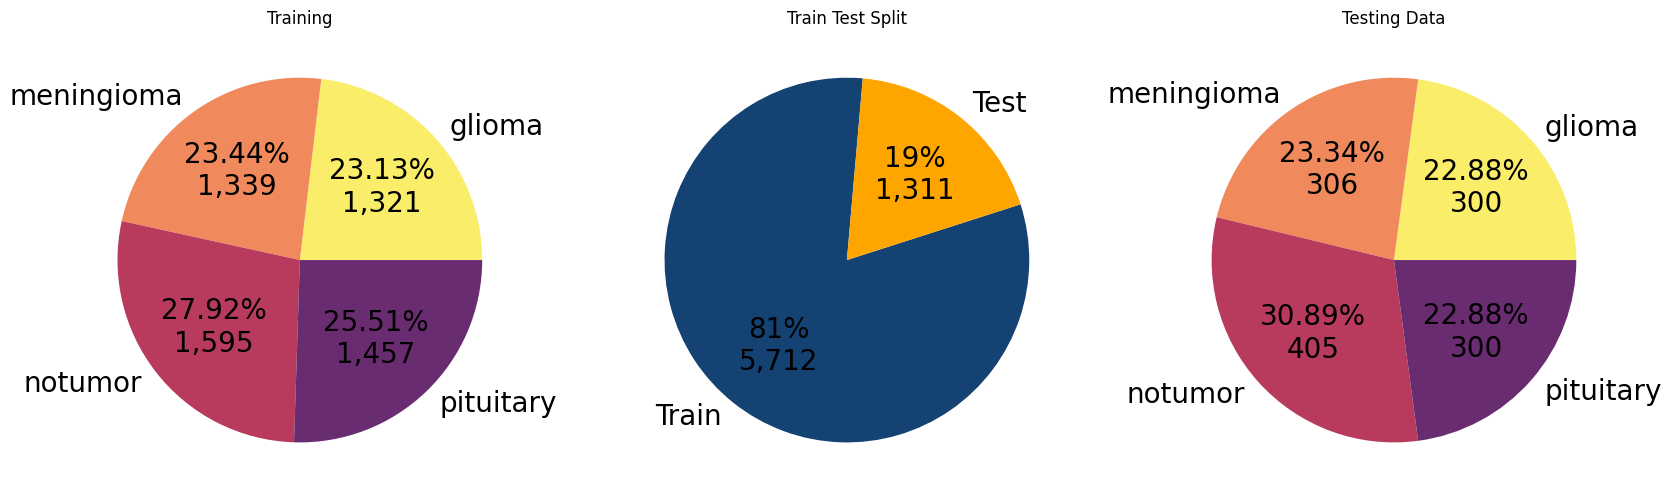

In [9]:
plot_data_splits(table,df_train,df_test,training_data,testing_data)

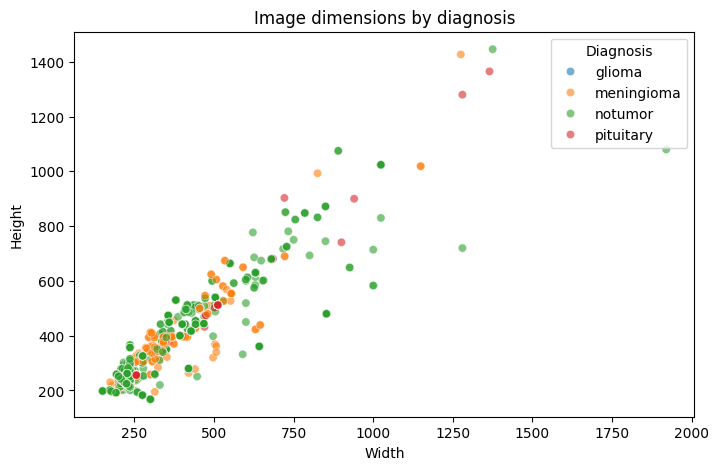

In [10]:
# Distribution of image dimensions 
plt.figure(figsize=(8,5))
sns.scatterplot(data = df, x='width',y='height', hue='diagnosis',alpha=0.6)
plt.title('Image dimensions by diagnosis')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(title='Diagnosis')
plt.show()

In [11]:
# Displaying the mode of images, shows inconsistency across images
df['mode'].value_counts()

mode
RGB     3926
L       3093
RGBA       3
P          1
Name: count, dtype: int64

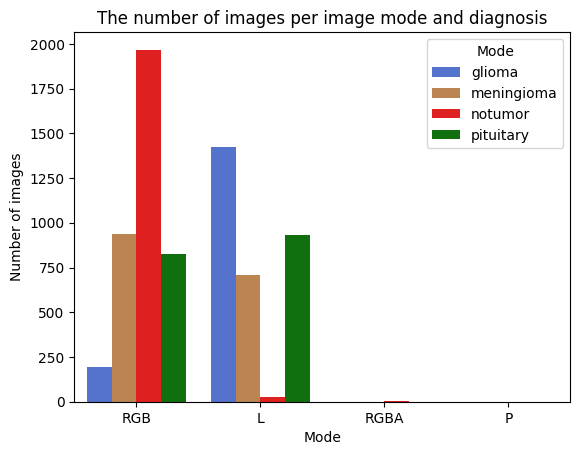

In [12]:
# The number
sns.countplot(data=df, x='mode', hue='diagnosis', palette=['royalblue', 'peru', 'red', 'green'],legend='full')
plt.title('The number of images per image mode and diagnosis')
plt.xlabel('Mode')
plt.ylabel('Number of images')
plt.legend(title='Mode')
plt.show()

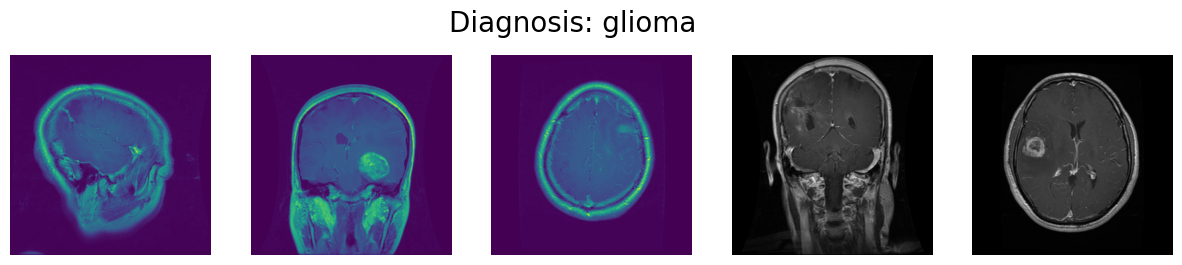

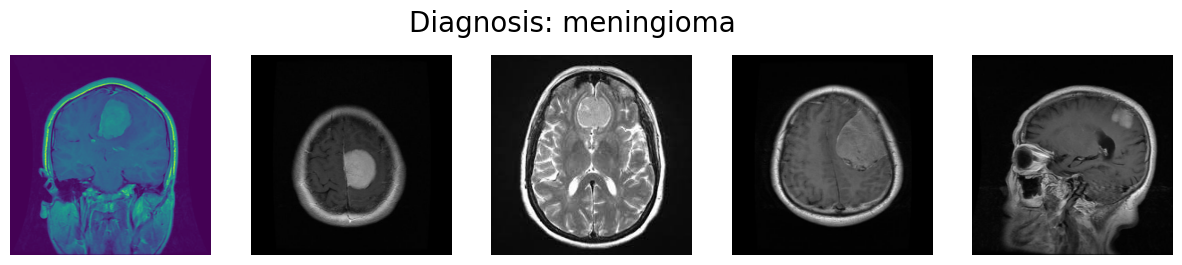

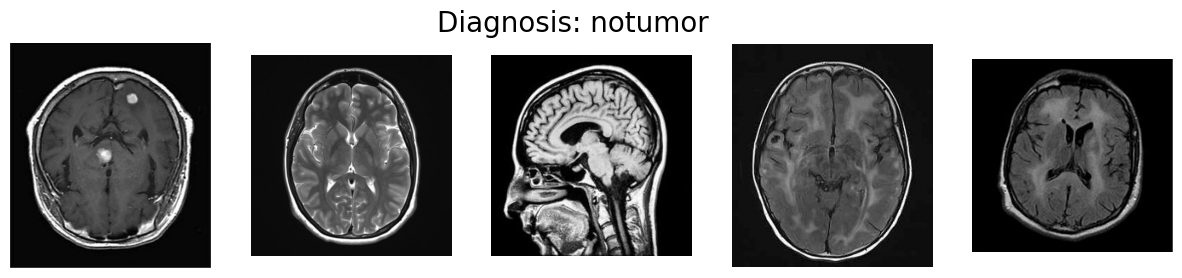

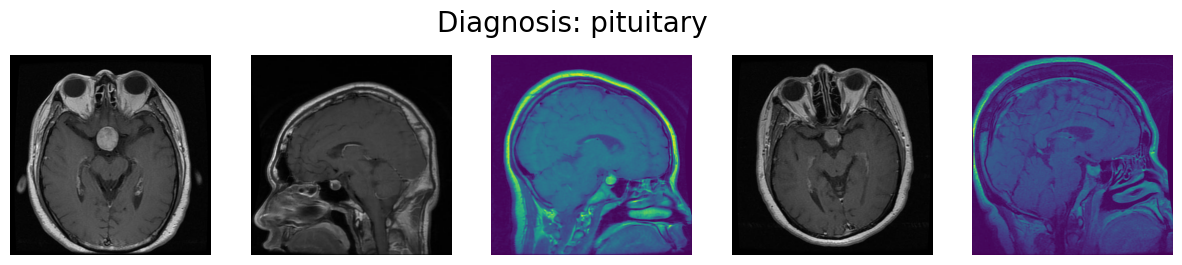

In [13]:
# Take 5 images from each diagnosis and visualise them, raw images without processing
for diag in diagnoses:
    samples = [item for item in image_data if item['diagnosis'] == diag]
    samples = random.sample(samples, k=5)  
    
    plt.figure(figsize=(15, 3))
    for i, item in enumerate(samples):
        plt.subplot(1, 5, i + 1)
        plt.imshow(item['image'])
        plt.axis('off')
    plt.suptitle(f"Diagnosis: {diag}",fontsize=20)
    plt.show()
    


## Findings
The brain tumors dataset consists of 4 different brain diagnoses: Glioma, meningioma, pituitary and healthy (known as notumor). There are 7023 images; 5645 for training (80%) and 1411 for testing (20%) divided closely between the four diagnoses, also each subset is well divided among the 4 classes with a maximum of 28.35% for healthy brain and a minimum of 22.89% for glioma in the training set, with nearly similar results for the testing set indicating a good class balance to start with.

However, the image dimensions by diagnosis chart shows a huge variance in image dimensions that needs to be handled as part of the data preparation, we need to choose a common image size for all the images which may affect the performance of the model as certain parts of the brain may/may not be taken when resizing especially when it comes to locating tumors within the brain. Also the fact that some images have different color modes (3926 RGB and 3093 Greyscale) so we need to ensure consistency among shapes and channels to avoid potential issues.

# Data Preparation

In [4]:
# Hashing images using MD5
# Source: https://mkyong.com/python/python-md5-hashing-example
def hash_image(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

# Collected all image paths and labels from both training and testing folders
def collect_images(dataset_path, subsets=('Training', 'Testing')):
    image_list = []
    for subset in subsets: # iterate over subsets
        subset_path = os.path.join(dataset_path, subset)
        diagnoses = os.listdir(subset_path)
        for diag in diagnoses: # iterate over diagnoses
            diag_folder = os.path.join(subset_path, diag)
            for img_file in os.listdir(diag_folder): # each image is added to the list
                img_path = os.path.join(diag_folder, img_file)
                image_list.append((img_path, diag))
    return image_list

# Remove duplicates using MD5 hash
# If two images have the same hash code, they are duplicate and we skip one of them
def remove_duplicates(images_with_labels):
    seen_hashes = {} # dict to stores hashes
    unique_images = [] # list of unique images
    for img_path, diag in images_with_labels:
        h = hash_image(img_path)
        if h not in seen_hashes: 
            seen_hashes[h] = img_path
            unique_images.append((img_path, diag)) 
        else:
            print(f"Duplicate found and skipped: {img_path}")
    return unique_images

# Shuffle and split data
def shuffle_and_split(images_with_labels, test_ratio=0.2): # we keep 80% of the data for training and 20% for testing 
    paths, diags = zip(*images_with_labels)
    return train_test_split(paths, diags, test_size=test_ratio, stratify=diags, random_state=111)

# Copy images to new cleaned dataset folder
def save_cleaned_dataset(split_data, cleaned_dataset_path='Cleaned_Dataset'):
    for subset, img_paths, diags in split_data:
        for img_path, diag in zip(img_paths, diags):
            dest_folder = Path(cleaned_dataset_path) / subset / diag
            dest_folder.mkdir(parents=True, exist_ok=True)
            shutil.copy2(img_path, dest_folder / os.path.basename(img_path))


# Making sure this happens only once
if os.path.exists(cleaned_dataset_path):
    print("Clean Dataset already exists")
else:
    images_with_labels = collect_images(dataset_path, subsets)
    unique_images = remove_duplicates(images_with_labels)
    train_paths, test_paths, train_diags, test_diags = shuffle_and_split(unique_images)

    save_cleaned_dataset([
        ("Training", train_paths, train_diags),
        ("Testing", test_paths, test_diags)
    ])

    print("Dataset is clean'")

Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0211.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0238.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0251.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0281.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0366.jpg
Duplicate found and skipped: Dataset/Training/meningioma/Tr-me_0617.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0012.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0014.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0024.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0029.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0077.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0078.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0079.jpg
Duplicate found and skipped: Dataset/Training/notumor/Tr-no_0081.jpg
Duplicate found 

In [10]:
df = pd.DataFrame(load_images(cleaned_dataset_path,subsets))
# Number of images for training and testing for each diagnosis
table = df.groupby(['subset', 'diagnosis']).size().unstack()
df_train = df[df['subset'] == 'Training']
df_test = df[df['subset'] == 'Testing']
training_data = table.loc['Training'] 
testing_data = table.loc['Testing']

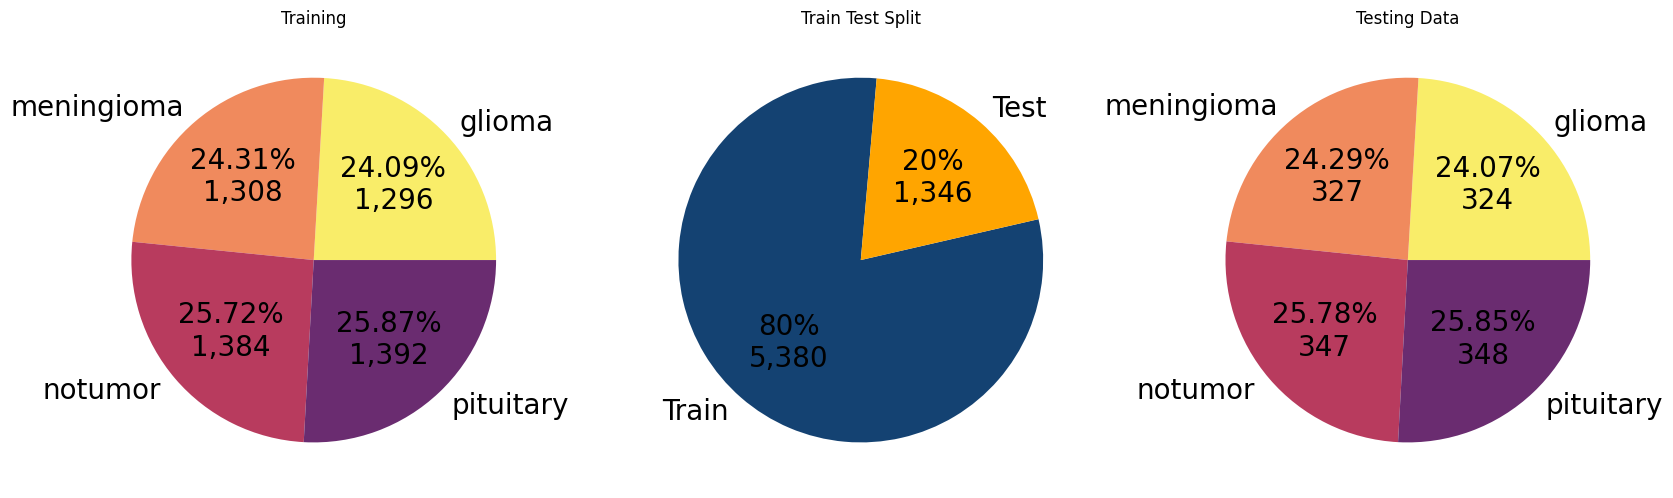

In [11]:
plot_data_splits(table,df_train,df_test,training_data,testing_data)

In [12]:
train_dir = 'Dataset/Training' # train images directory
test_dir = 'Dataset/Testing'  # test images directory
batch_size= 32 # define batch size
image_size = 224 # define image size

In [13]:
#load training data using image_dataset_from_directory
#source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,                                     
    label_mode= 'int',                             # Labels are encoded as a integers
    validation_split= 0.2,                         # 20% of the training data will be used for training
    color_mode = 'rgb',                            # Load all images in RGB mode 
    batch_size = batch_size,                       # number of images processed in each batch
    image_size = (image_size,image_size),          # image size is 224x224 (this will fix the imbalance we plotted earlier by using a uniform size)
    seed = 111,
    subset = 'training'                            # Training subset
)

#load validation data using image_dataset_from_directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode= 'int',
    validation_split= 0.2,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (image_size,image_size),
    shuffle = False,                                # Validation data isn't shuffled
    seed = 111,
    subset = 'validation'                           # Validation subset
)

#load validation data using image_dataset_from_directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode= 'int',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (image_size, image_size)
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1744077989.358019   57448 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [14]:
# Data augmentation
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers
data_augmentation = Sequential([
    RandomFlip('horizontal'),                                                             # Randomly flips images horizontally
    RandomRotation(0.03,fill_mode='constant'),                                            # Randomly rotates images by ±10 degrees
    RandomContrast(0.1),                                                                  # Randomly adjusts contrast by ±10%
    RandomZoom(height_factor=0.01, width_factor=0.05),                                    # Randomly zooms in/out up to 1% vertically and 5% horizontally
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),   # Randomly shifts the image by 0.15% of the height and width
])

rescale = Rescaling(1./255)  # Rescale pixel values to [0, 1] range

In [15]:
# Source: https://www.tensorflow.org/tutorials/images/data_augmentation

AUTOTUNE = tf.data.AUTOTUNE # Allows TensorFlow to automatically choose the optimal number of parallel threads to improve performance

# training data augmented and rescaled (Images were already resized when loaded so we don't need to resize again)
train_ds = train_ds.map(
    lambda x, y: (rescale(data_augmentation(x,training= True)), y),
    num_parallel_calls= AUTOTUNE
)

# Validation data rescaled only
val_ds = val_ds.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls= AUTOTUNE
)

# Testing data rescaled only
test_ds = test_ds.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls= AUTOTUNE
)

# Allows later elements to be prepared while the current element is being processed which improves performance
train_ds_preprocessed = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds_preprocessed = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
def visualize_augmentation(data, diagnoses, num_samples):
    
    # empty dictionary that will contain an image per diagnosis
    diagnoses_images = {diag: None for diag in range(len(diagnoses))}
    
    # Unbatch data and get individual images
    for image, label in data.unbatch().shuffle(1000):
        label = int(label.numpy()) # convert tensorflow label to a python integer
        if diagnoses_images[label] is None:  # If we didn't store an image
            img = (image.numpy() * 255).astype(np.uint8) # convert image to an array and we scale it back to 0-255 (img_size = 224)
            diagnoses_images[label] = img # we add the image to the dictionary
       
            
    
    # Create visualization grid
    num_diagnoses = len(diagnoses) 
    fig, axes = plt.subplots(
        num_diagnoses,
        num_samples + 1,
        figsize=(2.5*(num_samples+1), 2.5*num_diagnoses))
    
    for class_idx in range(num_diagnoses):
        # Original image taken earlier
        orig_img = diagnoses_images[class_idx]
        # Add it in the first column of each row 
        axes[class_idx, 0].imshow(orig_img)
        axes[class_idx, 0].set_title(f"Original\n{diagnoses[class_idx]}")
        axes[class_idx, 0].axis('off')
        
        for aug_idx in range(1, num_samples+1):
            # We augment the original images 
            aug_img = data_augmentation(tf.expand_dims(orig_img, 0))
            aug_img = aug_img[0].numpy().astype('uint8')

            # then we add it to the visualisation grid
            axes[class_idx, aug_idx].imshow(aug_img)
            axes[class_idx, aug_idx].set_title(f"Augmented image {aug_idx}")
            axes[class_idx, aug_idx].axis('off')
    
    plt.tight_layout()
    plt.show()


2025-04-08 03:06:43.144611: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


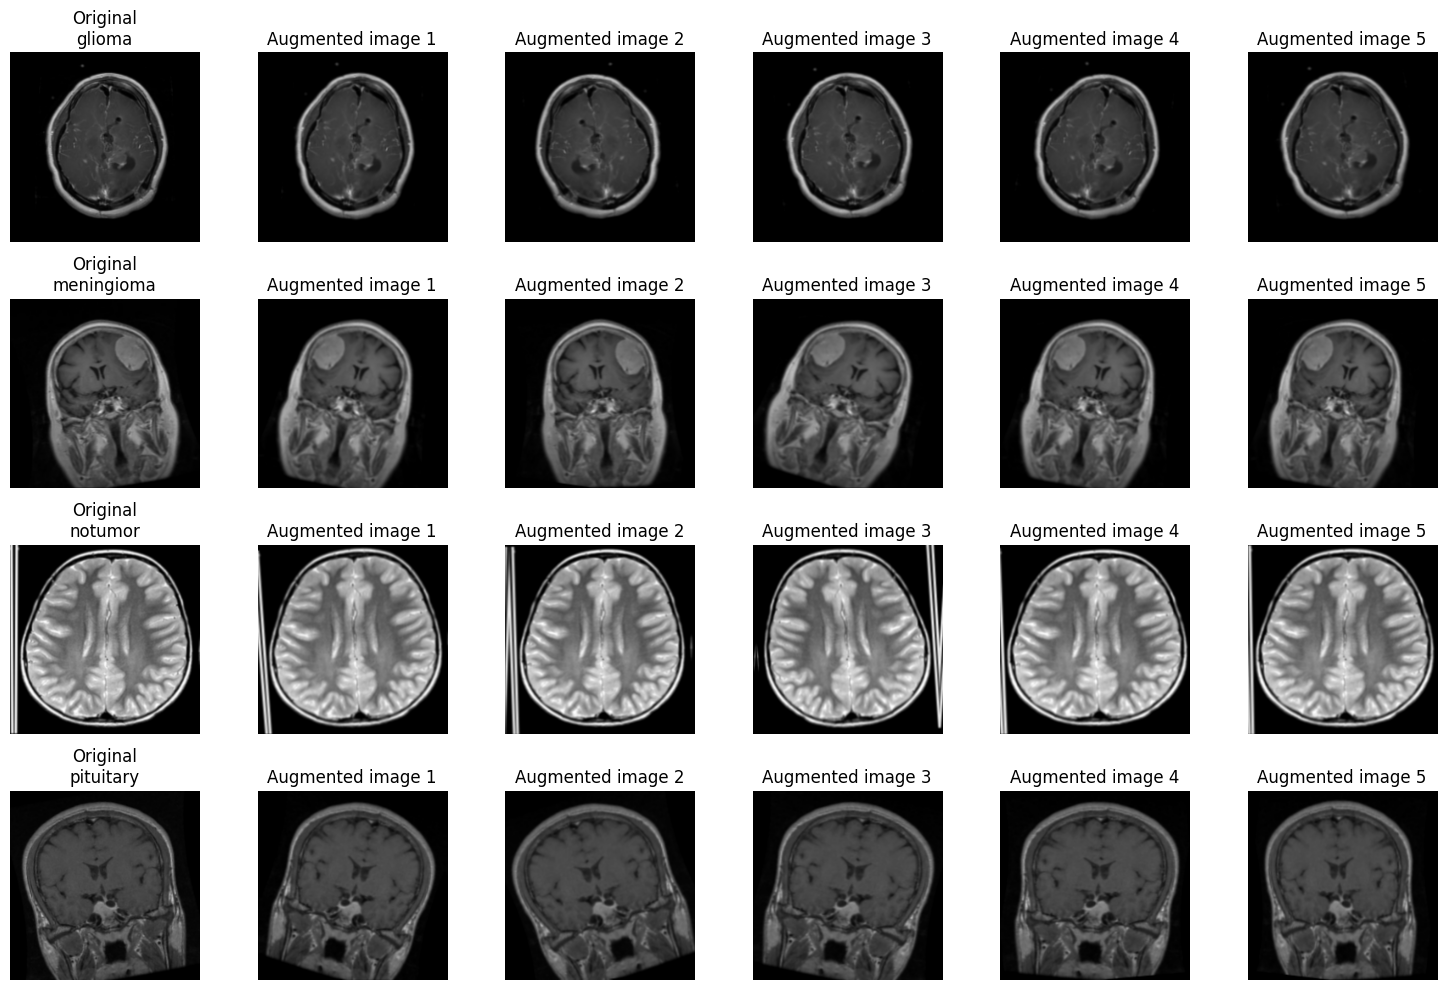

In [17]:
visualize_augmentation(
    data=train_ds,
    diagnoses = diagnoses,  
    num_samples=5
)

# Modelling

In [18]:
input_shape = (224,224,3)
num_classes= 4

In [20]:
def build_basic_cnn():
    model = Sequential([
        # First layer, 16 filters, 3x3 each
        # Relu activation for non-linearity, max(0,x)
        # MaxPooling reduces the spatial dimension taking the max in each 2x2 pool region, which makes training more computationally efficient
        Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),

        # Second layer
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        # Flatten transforms the 2D feature maps into a 1D vector
        Flatten(),
        # Final Dense layer (fully connected) with 'softmax' to output probabilities for each class
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3), 
        loss='sparse_categorical_crossentropy', # data is labelled as integers when loaded
        metrics=['accuracy'] # optimising based on accuracy
    )
    return model

# Build & train briefly for 10 epochs to have a general idea about our modelling scenarios
model_basic = build_basic_cnn()
history_v1 = model_basic.fit(
    train_ds_preprocessed, 
    validation_data=val_ds_preprocessed, 
    epochs=10
)

# Evaluate quickly on validation
val_loss_basic, val_acc_basic = model_basic.evaluate(test_ds_preprocessed)
print(f"Testing Accuracy: {val_acc_basic:.4f}")


Epoch 1/10


/home/rayen/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744078044.438351   57580 service.cc:152] XLA service 0xe6515d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744078044.438837   57580 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-04-08 03:07:24.581206: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744078044.899236   57580 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/143 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3154 - loss: 1.7995

I0000 00:00:1744078049.199763   57580 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.5695 - loss: 1.0409 - val_accuracy: 0.9518 - val_loss: 0.2446
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7966 - loss: 0.5116 - val_accuracy: 0.9790 - val_loss: 0.1218
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8627 - loss: 0.3810 - val_accuracy: 0.9790 - val_loss: 0.0890
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8582 - loss: 0.3674 - val_accuracy: 0.9947 - val_loss: 0.0446
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8759 - loss: 0.3227 - val_accuracy: 0.9851 - val_loss: 0.0783
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8854 - loss: 0.3025 - val_accuracy: 0.9947 - val_loss: 0.0541
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9003 - loss: 0.2628 - val_accuracy: 0.9974 - val_loss: 0.0204
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9129 - loss: 0.2387 - val_accuracy: 0.9